<a href="https://colab.research.google.com/github/HIRIS-Lab/HistologyHSI-GB/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is intended to provide an basic example of how to load and perform some basic preprocessing to hyperspectral data in ENVI format using Python.

This notebook was designed as a basic demonstration on how to load the data corresponding to the Recurrent Breast Cancer: Histopathological and Hyperspectral Images Database ([HistologyHSI-BRCA Recurrence Database](www.pagina_de_la_BBDD.com)) .

# 1) Setting up the environment and downloading the example data

### Libraries:
The libraries required for this notebook are Spectral Python (SPy), NumPy, SciPy, and Matplotlib.

> Spectral Python (SPy). Python module for hyperspectral image processing. https://www.spectralpython.net

> Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). https://doi.org/10.1038/s41586-020-2649-2

> J. D. Hunter, "Matplotlib: A 2D Graphics Environment," in Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, May-June 2007, doi: 10.1109/MCSE.2007.55.

> Virtanen, P., Gommers, R., Oliphant, T.E. et al. SciPy 1.0: fundamental algorithms for scientific computing in Python. Nat Methods 17, 261–272 (2020). https://doi.org/10.1038/s41592-019-0686-2





### Data:

In this tutorial, the data is directly downloaded from the TCIA using ascli. For more information on how to download data from TCIA, please consult this notebook: https://github.com/kirbyju/TCIA_Notebooks/blob/main/TCIA_Aspera_CLI_Downloads.ipynb.

The data used on this notebook correspond to a folder containing hyperspectral data from a brain histological slide from the HistologyHSI-GB dataset.  The hyperspectral cubes from the histological slide and the white and dark references are stored as ENVI files, the standard format for storing hyperspectral images. The ENVI format consists of a flat-binary raster file with an accompanying ASCII header file.

The folder contains the ENVI files from the histological slide and the necessary files for the calibration (dark and white reference). Additionally, the folder contains a synthetic RGB image extracted from the hyperspectral cube.



In [ ]:
# Install the Spectral Python (SPy) library
!pip install spectral
# Download a folder containing the hyperspectral data from the HistologyHSI-GB dataset from TCIA
!apt install -y ruby ruby-dev rubygems ruby-json
!gem install aspera-cli
!ascli conf ascp install
!ascli faspex5 packages receive --url='https://faspex.cancerimagingarchive.net/aspera/faspex/public/package?context=eyJyZXNvdXJjZSI6InBhY2thZ2VzIiwidHlwZSI6ImV4dGVybmFsX2Rvd25sb2FkX3BhY2thZ2UiLCJpZCI6Ijc2NCIsInBhc3Njb2RlIjoiMGU0MzFhYTFjN2ZhOGMwZWJmNTRhZDVkZTQxOGY5NWVlNmYyMjhlNiIsInBhY2thZ2VfaWQiOiI3NjQiLCJlbWFpbCI6ImhlbHBAY2FuY2VyaW1hZ2luZ2FyY2hpdmUubmV0In0=' P1/ROI_01_C01_T

# 2) Define helper functions to load and preprocessing the hyperspectral data

In [2]:
#########################################################
## Helper functions for loading and preprocessing data ##
#########################################################

import numpy as np
from spectral import *
import scipy
import json
import openslide
from PIL import Image, ImageDraw
from scipy.stats import norm
import pandas as pd

def read_hyperspectral_cube(file_name):
    """
    Function used to read an ENVI hyperspectral image, and return a numpy data structure containing the 3D hyperspectral cube

    Parameters
    ----------
    file_name : str
        The file location of the ENVI header related to the hyperspectral data.

    Returns
    -------
    hyperspectral_data: ndarray
        3-dimensional numpy array containing the hyperspectral cube
    wavelengths: ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube
    """

    ENVI_structure = envi.open(file_name)
    hyperspectral_data = ENVI_structure.load()
    wavelengths = ENVI_structure.bands.centers
    return hyperspectral_data, wavelengths

def hyperspectral_calibration(raw_data, white_reference, dark_reference):
    """
    Perform the calibration of a hyperspectral imaging using a white and dark reference images.

    Parameters
    ----------
    raw_data : ndarray
        Array containing the raw hyperspectral cube
    white_reference : ndarray
        Array containing the white reference
    dark_reference : ndarray
        Array containing the dark reference
    
    Returns
    -------
    ndarray
        Calibrated hyperspectral cube
    """
    return (raw_data-dark_reference)/(white_reference-dark_reference)

def band_reduction(input_data, wavelengths, n = 3):
    """
    Perform the band reduction to the hyperspectral cube

    Parameters
    ----------
    input_data : ndarray
        Array containing the raw hyperspectral cube
    wavelengths : ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube
    n : Integer
        Width of the window used for the moving average window.
    
    Returns
    -------
    band_reduced_cube: ndarray
        3-dimensional numpy array containing the hyperspectral cube after the band reduction
    wavelength_reduced: ndarray
        1-dimensional numpy array containing the spectral bands corresponding to the hyperspectral cube after the band reduction
    """
    w = np.ones(n)/n
    moving_averaged_image = scipy.ndimage.convolve1d(input_data, w, axis=2)
    band_reduced_cube = moving_averaged_image[:,:,1:-1:n]
    wavelength_reduced = wavelengths[1:-1:n]
    return band_reduced_cube, wavelength_reduced

def show_WSI_ROI(mrxs_path, geojson_path, tissue_type, capture_number):
    """
    Function used to obtain the region of interest (ROI) from a whole slide image (WSI)

    Parameters
    ----------
    mrxs_path : str
        The file location of the WSI in the MRXS format

    Returns
    -------
    masked_region: PIL.Image
        Image containing the region of interest (ROI) from the WSI
    """

    roi_name = f"{tissue_type}_{capture_number}"

    with open(geojson_path) as f:
        geojson_data = json.load(f)

    for i in range(len(geojson_data['features'])):
        if geojson_data['features'][i]['id'][0] == roi_name:
            roi_coordinates = geojson_data['features'][i]['geometry']['coordinates'][0][:4]
            break

    with openslide.OpenSlide(mrxs_path) as slide:
        shift_x = slide.properties['openslide.bounds-x']
        shift_x = int(shift_x)
        shift_y = slide.properties['openslide.bounds-y']
        shift_y = int(shift_y)

        roi_coordinates = [(x + shift_x, y + shift_y) for x, y in roi_coordinates]
        
        x_coords, y_coords = zip(*roi_coordinates)
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        width = x_max - x_min
        height = y_max - y_min

        bounding_box = slide.read_region(location=(x_min, y_min), level=0, size=(width, height))
        bounding_box = bounding_box.convert("RGB")

        mask = Image.new("L", (width, height), 0)
        polygon_relative = [(x - x_min, y - y_min) for x, y in roi_coordinates]
        ImageDraw.Draw(mask).polygon(polygon_relative, outline=255, fill=255)

        masked_region = Image.composite(bounding_box, Image.new("RGB", (width, height)), mask)
        
    return masked_region

def synthetic_RGB(hyperspectral_data, wavelengths):
    """
    Function used to generate a synthetic RGB image from a hyperspectral cube

    Parameters
    ----------
    hyperspectral_data : ndarray
        Array containing the hyperspectral cube
    wavelengths : ndarray
        1-dimensional numpy array containing the spectral bands corresponding to the hyperspectral cube

    Returns
    -------
    rgb: ndarray
        3-dimensional numpy array containing the synthetic RGB image
    """

    wavelengths = np.array(wavelengths, dtype=float)
    
    redWav = 590
    redStd = redWav * 0.08
    redComp = norm.pdf(wavelengths, redWav, redStd)

    greenWav = 560
    greenStd = greenWav * 0.06
    greenComp = norm.pdf(wavelengths, greenWav, greenStd)

    blueWav = 465
    blueStd = blueWav * 0.05
    blueComp = norm.pdf(wavelengths, blueWav, blueStd)

    red = np.tensordot(hyperspectral_data, redComp, axes=([2], [0]))
    green = np.tensordot(hyperspectral_data, greenComp, axes=([2], [0]))
    blue = np.tensordot(hyperspectral_data, blueComp, axes=([2], [0]))

    rgb = np.stack((red, green, blue), axis=-1)
    rgb = rgb / np.max(rgb)
    
    return rgb

def extract_patient_data(patient_data_path, patient_id):
    """
    Function used to extract the patient data from the .xlsx file containing the patient information

    Parameters
    ----------
    patient_data_path : str
        The file location of the 
    patient_id : int
        The patient ID for which the data will be extracted

    Returns
    -------
    patient_data: dict
        Dictionary containing the patient data
    """

    # load excel file
    patient_data = pd.read_excel(patient_data_path)

    # patient_data is a pandas dataframe with the following columns:
    # 'Case': Patient ID

    patient_data = patient_data[patient_data['Case'] == patient_id].to_dict(orient='records')[0]

    return patient_data


# 3) Load the hyperspectral images and check their sizes:

The raw hyperspectral image has a dimension of (800, 1004, 826), where the first two dimensions correspond to the spatial information (800x1004 pixels), and the third dimension corresponding to the spectral information (826 bands).

The white and dark reference have a dimension of (1, 1004, 826), since there is only information about a single line across the field of view of the camera. These reference were obtained as an average of 100 consecutive measurements of the white and dark references.

In [14]:
# Define the file names for the raw image, the white reference and the dark
# reference.
folder_path = ''
raw_file_name = f"{folder_path}/raw.hdr"
white_reference_file_name = f"{folder_path}/whiteReference.hdr"
dark_reference_file_name = f"{folder_path}/darkReference.hdr"
rgb_file_name = f"{folder_path}/RGBImage.png"
patient_data_path = ''

# Use the function read_hyperspectral_cube to load the ENVI files into numpy
# arrays. The spectral bands (wavelengths) for the white and dark references
# are the same ones we have for the hyperspectral cube, so it is no necesary
# to also get them.
raw_hyperspectral_image, wavelengths = read_hyperspectral_cube(raw_file_name)
white_reference, _ = read_hyperspectral_cube(white_reference_file_name)
dark_reference, _ = read_hyperspectral_cube(dark_reference_file_name)

# Display data dimensions:
print("Raw hyperspectral image dimensions: " + str(raw_hyperspectral_image.shape))
print("White reference dimensions: " + str(white_reference.shape))
print("Dark reference dimensions: " + str(dark_reference.shape))

# Display some information about the spectral bands:
print("Min. wavelength (nm): " + str(wavelengths[0]))
print("Max. wavelength (nm): " + str(wavelengths[-1]))
print("Distance between consecutive spectral bands (nm): " + str(np.mean(np.diff(wavelengths))))

Raw hyperspectral image dimensions: (600, 1004, 826)
White reference dimensions: (1, 1004, 826)
Dark reference dimensions: (1, 1004, 826)
Min. wavelength (nm): 400.482
Max. wavelength (nm): 1000.73
Distance between consecutive spectral bands (nm): 0.7275733333333334


# 4) Perform the calibration and the preprocessing:

In [7]:
# Perform the hyperspectral image calibration
calibrated_hyperspectral_image = hyperspectral_calibration(raw_hyperspectral_image, white_reference, dark_reference)

# TODO: Optional. Perform the band reduction.
band_reduced_hyperspectral_image, reduced_wavelengths = band_reduction(calibrated_hyperspectral_image, wavelengths)

# Display data dimensions:
print("Calibrated hyperspectral image dimensions: " + str(calibrated_hyperspectral_image.shape))
print("Band-reduced hyperspectral image dimensions: " + str(band_reduced_hyperspectral_image.shape))

# Display some information about the reduced spectral bands:
print("Min. wavelength (nm): " + str(reduced_wavelengths[0]))
print("Max. wavelength (nm): " + str(reduced_wavelengths[-1]))
print("Distance between consecutive spectral bands (nm): " + str(np.mean(np.diff(reduced_wavelengths))))

Calibrated hyperspectral image dimensions: (600, 1004, 826)
Band-reduced hyperspectral image dimensions: (600, 1004, 275)
Min. wavelength (nm): 401.21
Max. wavelength (nm): 999.276
Distance between consecutive spectral bands (nm): 2.1827226277372263


# 5) Representation of the information from the hyprespectral data:
## Visualizing the spatial information for different spectral bands

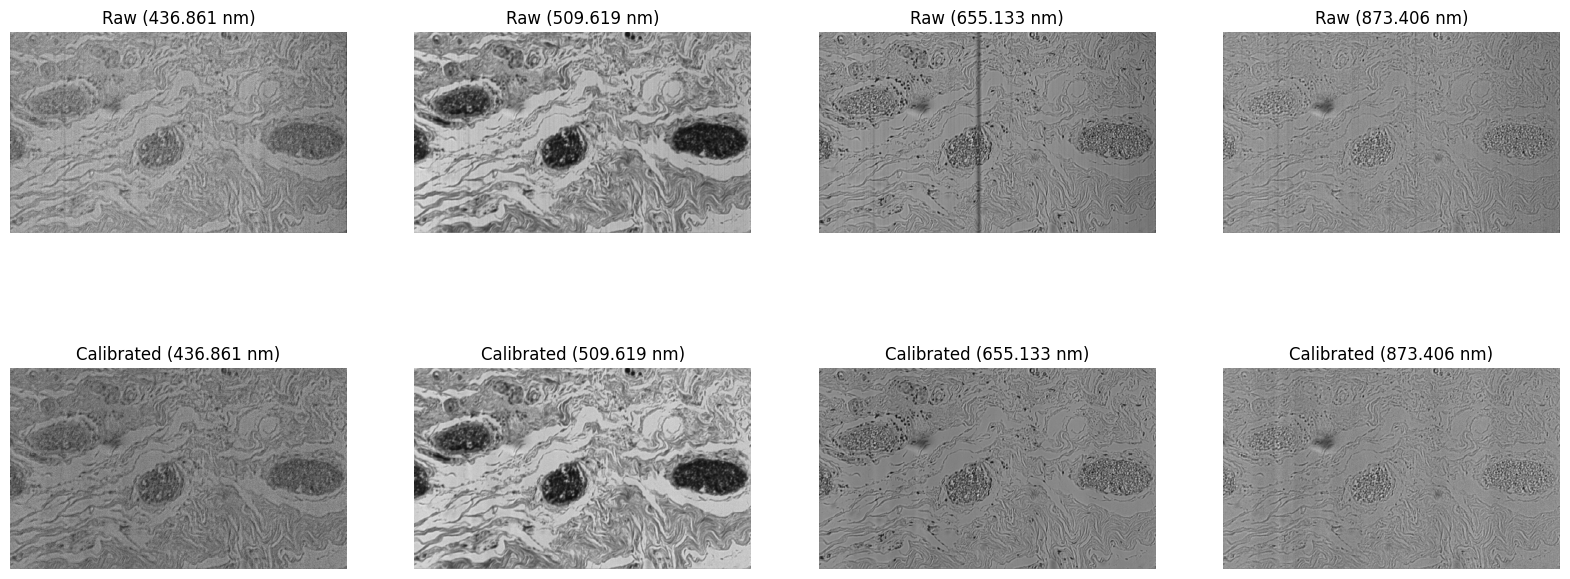

In [12]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2,4, figsize=(20, 8))

# TODO: Make this in a loop:
band_list = [50, 150, 350, 650]

for idx, current_band in enumerate(band_list):
  axarr[0,idx].imshow(raw_hyperspectral_image[:,:,current_band],cmap='gray')
  axarr[0,idx].set_title("Raw (" + str(wavelengths[current_band]) + " nm)")
  axarr[0,idx].axis('off')

  axarr[1,idx].imshow(calibrated_hyperspectral_image[:,:,current_band],cmap='gray')
  axarr[1,idx].set_title("Calibrated (" + str(wavelengths[current_band]) + " nm)")
  axarr[1,idx].axis('off')

plt.show()

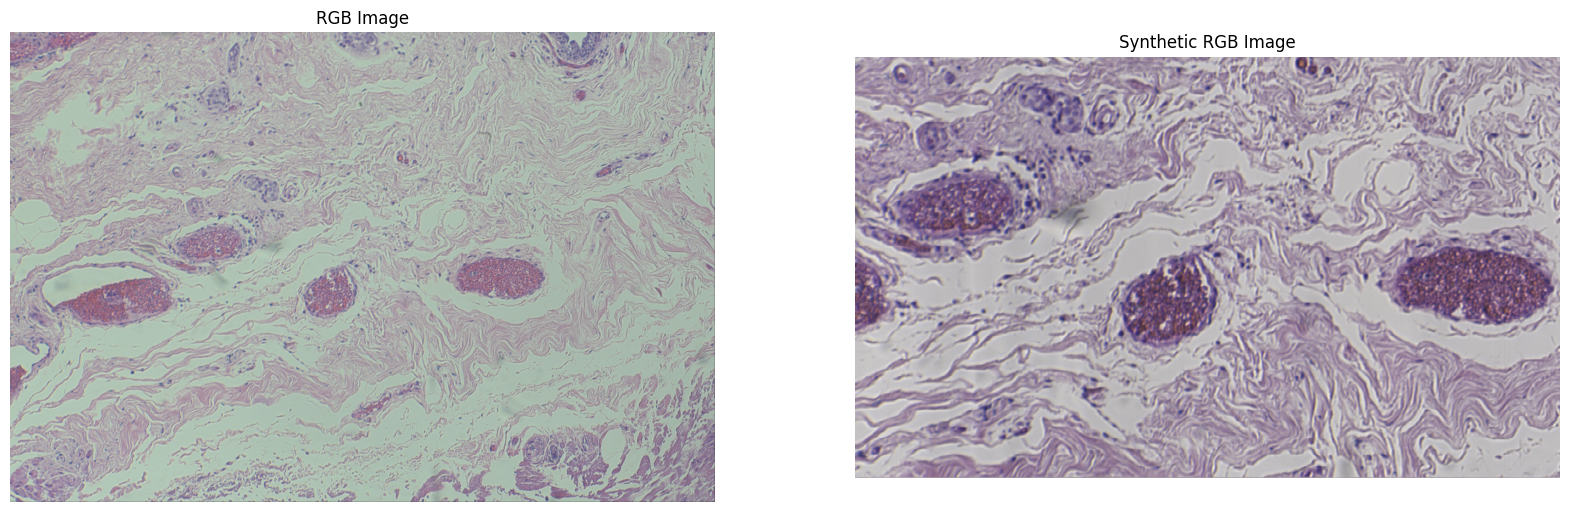

In [9]:
synthetic_rgb_image = synthetic_RGB(band_reduced_hyperspectral_image, reduced_wavelengths)

f, axarr = plt.subplots(1,2, figsize=(20, 8))
axarr[0].imshow(Image.open(rgb_file_name))
axarr[0].set_title("RGB Image")
axarr[0].axis('off')

axarr[1].imshow(synthetic_rgb_image)
axarr[1].set_title("Synthetic RGB Image")
axarr[1].axis('off')

plt.show()

## Visualizing the spectral information of different pixels

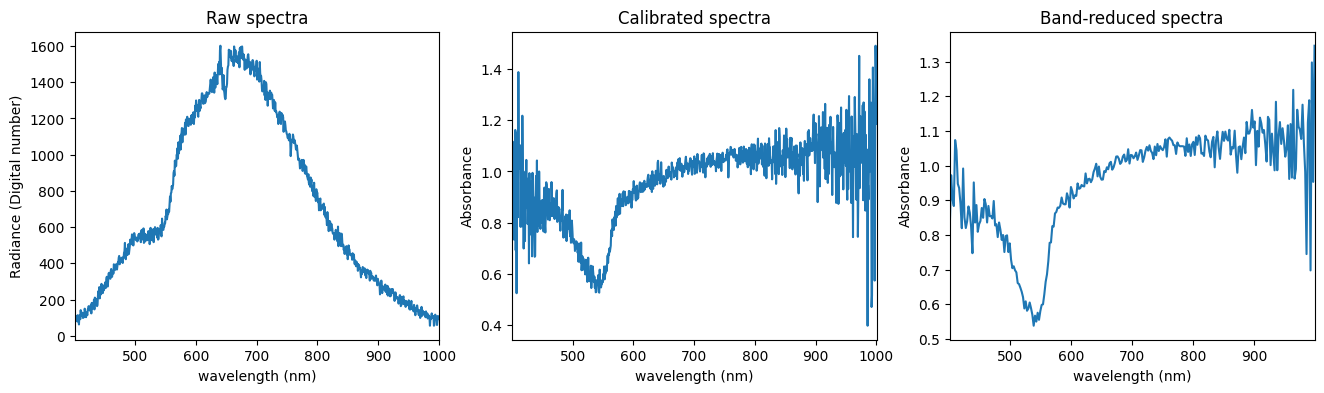

In [10]:
f, axarr = plt.subplots(1,3, figsize=(16, 4))

x_coordinate = 50
y_coordinate = 50

# Represent some bands from the raw image
axarr[0].plot(wavelengths, np.squeeze(raw_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[0].set_title("Raw spectra")
axarr[0].set_xlabel("wavelength (nm)")
axarr[0].set_ylabel("Radiance (Digital number)")
axarr[0].set_xlim(wavelengths[0], wavelengths[-1])


axarr[1].plot(wavelengths, np.squeeze(calibrated_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[1].set_title("Calibrated spectra")
axarr[1].set_xlabel("wavelength (nm)")
axarr[1].set_ylabel("Absorbance")
axarr[1].set_xlim(wavelengths[0], wavelengths[-1])


axarr[2].plot(reduced_wavelengths, np.squeeze(band_reduced_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[2].set_title("Band-reduced spectra")
axarr[2].set_xlabel("wavelength (nm)")
axarr[2].set_ylabel("Absorbance")
axarr[2].set_xlim(reduced_wavelengths[0], reduced_wavelengths[-1])

plt.show()


In [17]:
extract_patient_data(patient_data_path, 19)

{'Case': 19,
 'Sex': 1,
 'Race': 1,
 'Ethnicity': 1,
 'Menopausal_status': 0,
 'Dx_surgery': 1,
 'Dx_date': Timestamp('2007-08-14 00:00:00'),
 'Dx_age': 35,
 'Tumor_diameter': 17.0,
 'Tumor_histologic_grade': 2,
 'LVI': 1,
 'PNI': 0,
 'T': 1,
 'N': 2,
 'M': 0,
 'ER': 1,
 'PR': 1,
 'HER2': 0,
 'KI67': 1,
 'Molecular_subtype': 1,
 'LN_status': 3,
 'LN_ITC_number': 0,
 'LN_MICRO_number': 0,
 'LN_MACRO_number': 14,
 'LN_number': 25,
 'SLN_number': 0,
 'SLN_status': nan,
 'Tx_hormonal': 1,
 'Tx_CT': 1,
 'Tx_trastuzumab': 0,
 'Tx_RT': 1,
 'Last_follow_up': Timestamp('2021-08-24 00:00:00'),
 'Relapse': 1,
 'Metastasis_type': 2,
 'Relapse_date': Timestamp('2019-07-02 00:00:00'),
 'DFS': 142,
 'Vital_status': 1,
 'Death_date': Timestamp('2021-08-24 00:00:00'),
 'Death_cause': 1,
 'OS': 168}